In [ ]:
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import *
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.models import load_model
import os
from art.attacks import FastGradientMethod
from art.classifiers import KerasClassifier
import matplotlib.pyplot as plt
from numpy import load

In [8]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

## Data Preparation

In [9]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if True:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [10]:
model = load_model('Resnet18-200epochs.h5')
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.5075 - accuracy: 0.9138
Test loss: 0.5075193762779235
Test accuracy: 0.9138


In [21]:
classifier = KerasClassifier(model, clip_values=None, use_logits=False)

## FGSM Samples creation

In [10]:
fgsm1 = FastGradientMethod(classifier, eps=0.01)
train1 = fgsm1.generate(x_train)
test1 = fgsm1.generate(x_test)

In [11]:
fgsm2 = FastGradientMethod(classifier, eps=0.1)
train2 = fgsm2.generate(x_train)
test2 = fgsm2.generate(x_test)

## Saving and Loading for testing

In [25]:
from numpy import asarray
from numpy import save
save('fgsmtrain(0.01).npy', train1)
save('fgsmtest(0.01).npy', test1)
save('fgsmtrain(0.1).npy', train2)
save('fgsmtest(0.1).npy', test2)

In [24]:
from numpy import load
data = load('fgsmtest(0.01).npy')
predictions = model.predict(data)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on fgsm 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on fgsm 0.1 test examples: 24.97%


In [12]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

train3 = np.clip(x_train_noisy, 0., 1.)
test3 = np.clip(x_test_noisy, 0., 1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


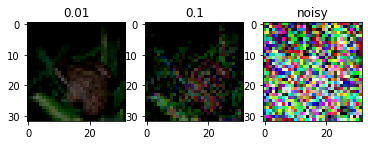

In [13]:
idx = 4
plt.subplot(1,3,1)
plt.imshow(test1[idx])
plt.title('0.01')
plt.subplot(1,3,2)
plt.imshow(test2[idx])
plt.title('0.1')
plt.subplot(1,3,3)
plt.imshow(test3[idx])
plt.title('noisy')
plt.show()

## Original Model Accuracy on FGSM Samples

In [14]:
predictions = model.predict(test1)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on fgsm 0.01 test examples: {}%".format(accuracy * 100))

Accuracy on fgsm 0.01 test examples: 24.97%


In [15]:
predictions = model.predict(test2)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on fgsm 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on fgsm 0.1 test examples: 9.58%


## DAE trained on eps = 0.01 fgsm samples solely

In [30]:
dae1 = denoising_autoencoder()
dae1.compile(optimizer='adam', loss='mse')

checkpoint = ModelCheckpoint('best_model1.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae1.fit(train1,
       train1,
       validation_data=(test1, test1),
       epochs=20,
       batch_size=128,
       callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
49920/50000 [============================>.] - ETA: 0s - loss: 0.0375
Epoch 00001: val_loss improved from inf to 0.03571, saving model to best_model1.h5
50000/50000 [==============================] - 106s 2ms/sample - loss: 0.0375 - val_loss: 0.0357
Epoch 2/20
49920/50000 [============================>.] - ETA: 0s - loss: 0.0301
Epoch 00002: val_loss improved from 0.03571 to 0.02929, saving model to best_model1.h5
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0301 - val_loss: 0.0293
Epoch 3/20
49920/50000 [============================>.] - ETA: 0s - loss: 0.0298
Epoch 00003: val_loss improved from 0.02929 to 0.02911, saving model to best_model1.h5
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0298 - val_loss: 0.0291
Epoch 4/20
49920/50000 [============================>.] - ETA: 0s - loss: 0.0297
Epoch 00004: val_loss improved from 0.02911 to 0.02883, saving model to best_mod

In [33]:
test11 = dae1.predict(test1)
test12 = dae1.predict(x_test)
test13 = dae1.predict(test2)

pred1 = model.predict(test11)
pred2 = model.predict(test12)
pred3 = model.predict(test13)

accuracy = np.sum(np.argmax(pred1, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.01 test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on Original test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred3, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on denoised 0.01 test examples: 38.92%
Accuracy on Original test examples: 53.56999999999999%
Accuracy on denoised 0.1 test examples: 12.3%


## DAE trained on eps = 0.1 fgsm samples solely

In [26]:
dae2 = denoising_autoencoder()
dae2.compile(optimizer='adam', loss='mse')

checkpoint = ModelCheckpoint('best_model2.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae2.fit(train2,
       train2,
       validation_data=(test2, test2),
       epochs=40,
       batch_size=128,
       callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0428
Epoch 00001: val_loss improved from inf to 0.04033, saving model to best_model2.h5
50000/50000 [==============================] - 103s 2ms/sample - loss: 0.0428 - val_loss: 0.0403
Epoch 2/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0364
Epoch 00002: val_loss improved from 0.04033 to 0.03521, saving model to best_model2.h5
50000/50000 [==============================] - 99s 2ms/sample - loss: 0.0364 - val_loss: 0.0352
Epoch 3/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0358
Epoch 00003: val_loss improved from 0.03521 to 0.03485, saving model to best_model2.h5
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0358 - val_loss: 0.0348
Epoch 4/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0355
Epoch 00004: val_loss improved from 0.03485 to 0.03455, saving model to best_mod

Epoch 34/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0343
Epoch 00034: val_loss did not improve from 0.03350
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0343 - val_loss: 0.0335
Epoch 35/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0343
Epoch 00035: val_loss improved from 0.03350 to 0.03348, saving model to best_model2.h5
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.0343 - val_loss: 0.0335
Epoch 36/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0343
Epoch 00036: val_loss improved from 0.03348 to 0.03347, saving model to best_model2.h5
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.0343 - val_loss: 0.0335
Epoch 37/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.0343
Epoch 00037: val_loss did not improve from 0.03347
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.0343 - val_loss: 0.0335
Epoch 38/40


In [27]:
test11 = dae2.predict(test1)
test12 = dae2.predict(x_test)
test13 = dae2.predict(test2)

pred1 = model.predict(test11)
pred2 = model.predict(test12)
pred3 = model.predict(test13)

accuracy = np.sum(np.argmax(pred1, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.01 test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on Original test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred3, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on denoised 0.01 test examples: 35.260000000000005%
Accuracy on Original test examples: 54.92%
Accuracy on denoised 0.1 test examples: 10.209999999999999%


## DAE trained on eps = 0.01 fgsm samples and clean data

In [31]:
dae4 = denoising_autoencoder()
dae4.compile(optimizer='adam', loss='mse')

checkpoint = ModelCheckpoint('best_model4.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae3.fit(train1,
       x_train,
       validation_data=(test1, x_test),
       epochs=30,
       batch_size=128,
       callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0351
Epoch 00001: val_loss improved from inf to 0.03377, saving model to best_model4.h5
50000/50000 [==============================] - 107s 2ms/sample - loss: 0.0351 - val_loss: 0.0338
Epoch 2/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0300
Epoch 00002: val_loss improved from 0.03377 to 0.02925, saving model to best_model4.h5
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0300 - val_loss: 0.0292
Epoch 3/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0297
Epoch 00003: val_loss improved from 0.02925 to 0.02882, saving model to best_model4.h5
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.0297 - val_loss: 0.0288
Epoch 4/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0296
Epoch 00004: val_loss improved from 0.02882 to 0.02874, saving model to best_mod

In [34]:
test11 = dae4.predict(test1)
test12 = dae4.predict(x_test)
test13 = dae4.predict(test2)

pred1 = model.predict(test11)
pred2 = model.predict(test12)
pred3 = model.predict(test13)

accuracy = np.sum(np.argmax(pred1, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.01 test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on Original test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred3, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on denoised 0.01 test examples: 10.7%
Accuracy on Original test examples: 10.73%
Accuracy on denoised 0.1 test examples: 10.8%


## DAE trained on eps = 0.1 fgsm samples and clean samples

In [32]:
dae5 = denoising_autoencoder()
dae5.compile(optimizer='adam', loss='mse')

checkpoint = ModelCheckpoint('best_model5.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae5.fit(train2,
       x_train,
       validation_data=(test2, x_test),
       epochs=30,
       batch_size=128,
       callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0362
Epoch 00001: val_loss improved from inf to 0.03114, saving model to best_model5.h5
50000/50000 [==============================] - 106s 2ms/sample - loss: 0.0361 - val_loss: 0.0311
Epoch 2/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0306
Epoch 00002: val_loss improved from 0.03114 to 0.03061, saving model to best_model5.h5
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0306 - val_loss: 0.0306
Epoch 3/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0303
Epoch 00003: val_loss improved from 0.03061 to 0.02940, saving model to best_model5.h5
50000/50000 [==============================] - 97s 2ms/sample - loss: 0.0303 - val_loss: 0.0294
Epoch 4/30
49920/50000 [============================>.] - ETA: 0s - loss: 0.0302
Epoch 00004: val_loss improved from 0.02940 to 0.02933, saving model to best_mod

In [35]:
test11 = dae5.predict(test1)
test12 = dae5.predict(x_test)
test13 = dae5.predict(test2)

pred1 = model.predict(test11)
pred2 = model.predict(test12)
pred3 = model.predict(test13)

accuracy = np.sum(np.argmax(pred1, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.01 test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on Original test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred3, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on denoised 0.01 test examples: 45.26%
Accuracy on Original test examples: 46.57%
Accuracy on denoised 0.1 test examples: 31.430000000000003%
